# Step 2: Train Baseline XGBoost Model
## Privacy-Preserving Cognitive Twin Project
### Data Lead: Kevin Williams
---

**Objective**: Train baseline model and establish performance target

**Key Metrics to Track**:
- Accuracy
- F1 Score (macro)
- AUROC (macro)
- Expected Calibration Error (ECE)
- Confusion Matrix
- Feature Importance

**Inputs**: 
- X_train.csv, y_train.csv (from Step 1C)
- X_val.csv, y_val.csv (from Step 1C)
- X_test.csv, y_test.csv (from Step 1C)

**Outputs**: 
- baseline_metrics.json (performance metrics)
- feature_importance.csv (feature importance)
- baseline_model.json (trained model)

## Cell 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json

# FROZEN PARAMETER
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ Libraries imported")
print(f"✓ Random seed: {RANDOM_SEED}")

✓ Libraries imported
✓ Random seed: 42


## Cell 2: Load Train/Val/Test Data

In [3]:
# Cell 2: Load Train/Val/Test Data

# Load split data from Step 1C
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')

y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

# Drop non-numeric columns from X sets BEFORE any processing
cols_to_drop = ['Subject', 'Label']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

print("✓ Data loaded")
print(f"\nTrain set: {X_train.shape}")
print(f"Val set:   {X_val.shape}")
print(f"Test set:  {X_test.shape}")

# Extract labels as 1D arrays
y_train_labels = y_train['Label'].values
y_val_labels = y_val['Label'].values
y_test_labels = y_test['Label'].values

print(f"\nLabel shape check:")
print(f"  y_train: {y_train_labels.shape}")
print(f"  y_val: {y_val_labels.shape}")
print(f"  y_test: {y_test_labels.shape}")

✓ Data loaded

Train set: (1140, 84)
Val set:   (97, 84)
Test set:  (190, 84)

Label shape check:
  y_train: (1140,)
  y_val: (97,)
  y_test: (190,)


## Cell 3: Initialize and Train XGBoost Model

XGBoost Configuration (LOCKED):
- n_estimators: 100
- max_depth: 6
- learning_rate: 0.1
- random_state: 42

In [4]:
# Cell 3: Initialize and Train XGBoost Model with Randomized Search

print("\n" + "="*70)
print("TRAINING XGBOOST MODEL WITH RANDOMIZED SEARCH")
print("="*70)

print(f"Training with {X_train.shape[1]} features")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Check class distribution
print("\nClass distribution:")
unique, counts = np.unique(y_train_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count} samples ({count/len(y_train_labels)*100:.1f}%)")

# Calculate class weights
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

sample_weights = compute_sample_weight('balanced', y_train_labels)

print("\n✓ Applying balanced sample weights")
print("✓ Starting Randomized Search for optimal hyperparameters...")

# Define parameter distributions (wider range)
param_distributions = {
    'max_depth': randint(3, 7),                    # Random int between 3-6
    'learning_rate': uniform(0.01, 0.2),           # Random float 0.01-0.21
    'n_estimators': randint(50, 200),              # Random int 50-199
    'subsample': uniform(0.6, 0.4),                # Random float 0.6-1.0
    'colsample_bytree': uniform(0.6, 0.4),         # Random float 0.6-1.0
    'min_child_weight': randint(1, 7),             # Random int 1-6
    'gamma': uniform(0, 0.3),                      # Random float 0-0.3
    'reg_alpha': uniform(0, 1.0),                  # Random float 0-1.0
    'reg_lambda': uniform(0.5, 2.5)                # Random float 0.5-3.0
}

# Base XGBoost classifier
base_model = xgb.XGBClassifier(
    random_state=RANDOM_SEED,
    verbosity=0,
    eval_metric='mlogloss'
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,                      # Try 50 random combinations
    cv=3,                           # 3-fold cross-validation
    scoring='f1_macro',             # Optimize for F1 macro
    n_jobs=-1,                      # Use all CPU cores
    verbose=2,                      # Show progress
    random_state=RANDOM_SEED,
    return_train_score=True
)

print("\nRandomized Search will try 50 parameter combinations...")
print("="*70)

# Fit randomized search with sample weights
random_search.fit(
    X_train, y_train_labels,
    sample_weight=sample_weights
)

print("\n" + "="*70)
print("✓ Randomized Search complete!")

# Get best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\nBest Parameters Found:")
for param, value in best_params.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

print(f"\nBest Cross-Validation F1 Score: {best_score:.4f}")

# Retrain with early stopping (CORRECT WAY)
print("\nRetraining best model with early stopping on validation set...")

# Create NEW model with best parameters + early stopping
model = xgb.XGBClassifier(
    **best_params,                  # Unpack best parameters
    random_state=RANDOM_SEED,
    verbosity=1,
    eval_metric='mlogloss',
    early_stopping_rounds=10        # Add early stopping HERE
)

# Train with early stopping
model.fit(
    X_train, y_train_labels,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val_labels)],
    verbose=True
)

print("\n" + "="*70)
print("✓ Final model training complete")

if hasattr(model, 'best_iteration'):
    print(f"Best iteration: {model.best_iteration}")
    print(f"Best validation score: {model.best_score:.4f}")

# Show top 5 parameter combinations
print("\nTop 5 Parameter Combinations:")
results_df = pd.DataFrame(random_search.cv_results_)
top_5 = results_df.nsmallest(5, 'rank_test_score')[
    ['mean_test_score', 'std_test_score', 'mean_train_score', 'params']
]

for idx, (i, row) in enumerate(top_5.iterrows(), 1):
    train_test_gap = row['mean_train_score'] - row['mean_test_score']
    print(f"\n  Rank {idx}:")
    print(f"    Test F1:  {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"    Train F1: {row['mean_train_score']:.4f}")
    print(f"    Gap:      {train_test_gap:.4f}")


TRAINING XGBOOST MODEL WITH RANDOMIZED SEARCH
Training with 84 features
Training samples: 1140
Validation samples: 97

Class distribution:
  Class 0: 692 samples (60.7%)
  Class 1: 240 samples (21.1%)
  Class 2: 132 samples (11.6%)
  Class 3: 76 samples (6.7%)

✓ Applying balanced sample weights
✓ Starting Randomized Search for optimal hyperparameters...

Randomized Search will try 50 parameter combinations...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✓ Randomized Search complete!

Best Parameters Found:
  colsample_bytree: 0.7901
  gamma: 0.1690
  learning_rate: 0.1491
  max_depth: 3
  min_child_weight: 5
  n_estimators: 192
  reg_alpha: 0.7556
  reg_lambda: 1.0720
  subsample: 0.6308

Best Cross-Validation F1 Score: 0.6472

Retraining best model with early stopping on validation set...
[0]	validation_0-mlogloss:1.28012
[1]	validation_0-mlogloss:1.18687
[2]	validation_0-mlogloss:1.11548
[3]	validation_0-mlogloss:1.04422
[4]	validation_0-mlogloss:0.96293
[5]	valid

## Cell 4: Make Predictions on Test Set

In [5]:
# Cell 4: Generate Predictions

print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

# Predictions (features already cleaned)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Probability predictions (for AUROC, calibration)
y_proba_train = model.predict_proba(X_train)
y_proba_val = model.predict_proba(X_val)
y_proba_test = model.predict_proba(X_test)

print("✓ Predictions generated")
print(f"\nPrediction shapes:")
print(f"  y_pred_train: {y_pred_train.shape}")
print(f"  y_pred_val: {y_pred_val.shape}")
print(f"  y_pred_test: {y_pred_test.shape}")
print(f"\nProbability shapes:")
print(f"  y_proba_train: {y_proba_train.shape}")
print(f"  y_proba_val: {y_proba_val.shape}")
print(f"  y_proba_test: {y_proba_test.shape}")


GENERATING PREDICTIONS
✓ Predictions generated

Prediction shapes:
  y_pred_train: (1140,)
  y_pred_val: (97,)
  y_pred_test: (190,)

Probability shapes:
  y_proba_train: (1140, 4)
  y_proba_val: (97, 4)
  y_proba_test: (190, 4)


## Cell 5: Calculate Performance Metrics

In [6]:
# ACCURACY
acc_train = accuracy_score(y_train_labels, y_pred_train)
acc_val = accuracy_score(y_val_labels, y_pred_val)
acc_test = accuracy_score(y_test_labels, y_pred_test)

# F1 SCORE (macro)
f1_train = f1_score(y_train_labels, y_pred_train, average='macro')
f1_val = f1_score(y_val_labels, y_pred_val, average='macro')
f1_test = f1_score(y_test_labels, y_pred_test, average='macro')

# F1 per class
f1_per_class_test = f1_score(y_test_labels, y_pred_test, average=None)

# AUROC (macro)
auroc_train = roc_auc_score(y_train_labels, y_proba_train, multi_class='ovr', average='macro')
auroc_val = roc_auc_score(y_val_labels, y_proba_val, multi_class='ovr', average='macro')
auroc_test = roc_auc_score(y_test_labels, y_proba_test, multi_class='ovr', average='macro')

# AUROC per class
auroc_per_class_test = roc_auc_score(y_test_labels, y_proba_test, multi_class='ovr', average=None)

print("✓ Metrics calculated")
print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc_test:.4f}")
print(f"  F1 (macro): {f1_test:.4f}")
print(f"  AUROC (macro): {auroc_test:.4f}")

✓ Metrics calculated

Test Set Performance:
  Accuracy: 0.7474
  F1 (macro): 0.5736
  AUROC (macro): 0.8904


## Cell 6: Calculate Expected Calibration Error (ECE)

In [7]:
def compute_ece(y_true, y_proba, y_pred, n_bins=10):
    """
    Compute Expected Calibration Error
    For multi-class: use max probability
    
    Args:
        y_true: true labels
        y_proba: predicted probabilities (n_samples, n_classes)
        y_pred: predicted labels
        n_bins: number of bins for calibration
    """
    # Get max probability for each sample
    y_proba_max = y_proba.max(axis=1)
    
    # Check if predictions are correct
    y_pred_correct = (y_pred == y_true).astype(int)
    
    # Bin samples by confidence
    bin_sums = np.zeros(n_bins)
    bin_total = np.zeros(n_bins)
    
    for i in range(n_bins):
        bin_lower = i / n_bins
        bin_upper = (i + 1) / n_bins
        
        in_bin = (y_proba_max >= bin_lower) & (y_proba_max < bin_upper)
        if in_bin.sum() > 0:
            bin_accuracy = y_pred_correct[in_bin].mean()
            bin_confidence = y_proba_max[in_bin].mean()
            bin_sums[i] = np.abs(bin_accuracy - bin_confidence) * in_bin.sum()
            bin_total[i] = in_bin.sum()
    
    ece = np.sum(bin_sums) / np.sum(bin_total) if np.sum(bin_total) > 0 else 0
    return ece

# Compute ECE for all splits
ece_train = compute_ece(y_train_labels, y_proba_train, y_pred_train)
ece_val = compute_ece(y_val_labels, y_proba_val, y_pred_val)
ece_test = compute_ece(y_test_labels, y_proba_test, y_pred_test)

print(f"✓ ECE calculated")
print(f"  Train ECE: {ece_train:.4f}")
print(f"  Val ECE:   {ece_val:.4f}")
print(f"  Test ECE:  {ece_test:.4f}")

✓ ECE calculated
  Train ECE: 0.0895
  Val ECE:   0.1023
  Test ECE:  0.0508


## Cell 7: Confusion Matrix

✓ Confusion matrix computed

Confusion Matrix (Test Set):
[[89  7 13  7]
 [ 2 37  0  0]
 [ 7  0 16  0]
 [12  0  0  0]]


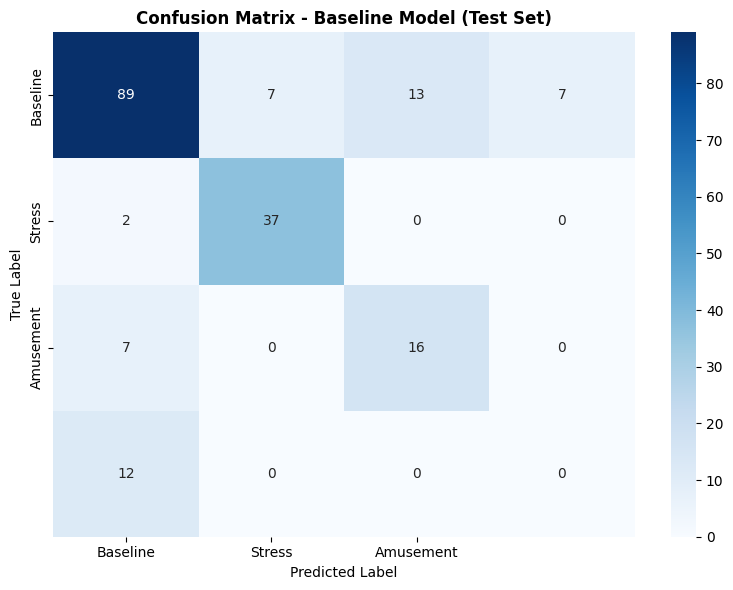

In [8]:
# Confusion matrix
cm_test = confusion_matrix(y_test_labels, y_pred_test)

print("✓ Confusion matrix computed")
print(f"\nConfusion Matrix (Test Set):")
print(cm_test)

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
label_names = ['Baseline', 'Stress', 'Amusement']
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, ax=ax)
ax.set_title('Confusion Matrix - Baseline Model (Test Set)', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Cell 8: Feature Importance


FEATURE IMPORTANCE ANALYSIS
✓ Feature importance extracted

Top 15 Important Features:
         feature  importance
            Time    0.061950
     HRV_Prc20NN    0.048996
       HRV_MinNN    0.044617
    HRV_MedianNN    0.036584
       HRV_pNN20    0.030779
         HRV_LFn    0.025663
      HRV_MeanNN    0.024895
HRV_CSI_Modified    0.024588
     HRV_Prc80NN    0.022626
         HRV_HFn    0.021720
         HRV_PIP    0.021028
        HRV_SD1a    0.020333
     HRV_FuzzyEn    0.019325
         HRV_CVI    0.017242
        HRV_IALS    0.016941


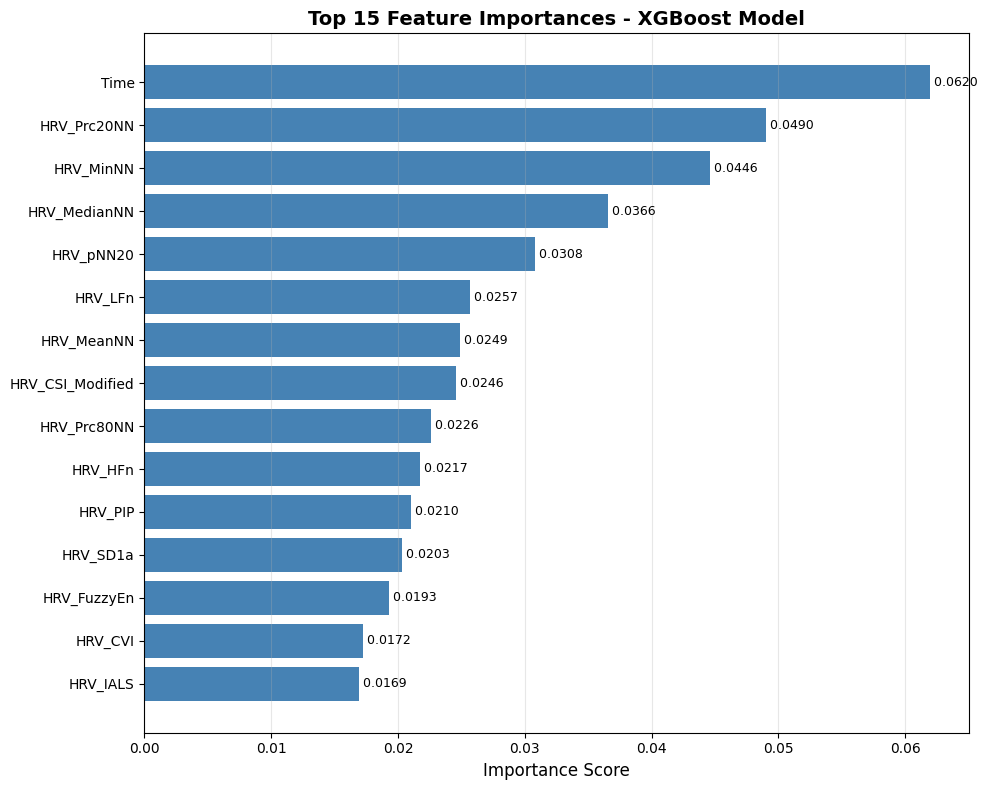


✓ Total features: 84
✓ Top feature: Time (importance: 0.0620)


In [9]:
# Cell 8: Feature Importance Analysis

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Extract feature importance (X_train already has correct columns)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("✓ Feature importance extracted")
print(f"\nTop 15 Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)

ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances - XGBoost Model', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Add importance values on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'], i, f" {row['importance']:.4f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"✓ Total features: {len(feature_importance)}")
print(f"✓ Top feature: {feature_importance.iloc[0]['feature']} "
      f"(importance: {feature_importance.iloc[0]['importance']:.4f})")

## Cell 9: Print Comprehensive Summary

In [10]:
print("\n" + "="*70)
print("BASELINE MODEL PERFORMANCE REPORT")
print("="*70)

print("\n1. ACCURACY")
print(f"   Train: {acc_train:.4f}")
print(f"   Val:   {acc_val:.4f}")
print(f"   Test:  {acc_test:.4f}")

print("\n2. F1 SCORE (Macro)")
print(f"   Train: {f1_train:.4f}")
print(f"   Val:   {f1_val:.4f}")
print(f"   Test:  {f1_test:.4f}")
print(f"   Per class: {f1_per_class_test}")

print("\n3. AUROC (Macro)")
print(f"   Train: {auroc_train:.4f}")
print(f"   Val:   {auroc_val:.4f}")
print(f"   Test:  {auroc_test:.4f}")
print(f"   Per class: {auroc_per_class_test}")

print("\n4. EXPECTED CALIBRATION ERROR")
print(f"   Train: {ece_train:.4f}")
print(f"   Val:   {ece_val:.4f}")
print(f"   Test:  {ece_test:.4f}")

print("\n5. CONFUSION MATRIX (Test Set)")
print(cm_test)

print("\n" + "="*70)
print("OVERFITTING CHECK")
print("="*70)
acc_gap = acc_train - acc_test
f1_gap = f1_train - f1_test
print(f"Accuracy gap (train-test): {acc_gap:.4f}")
print(f"F1 gap (train-test): {f1_gap:.4f}")
if acc_gap < 0.05 and f1_gap < 0.05:
    print("✓ Good generalization, minimal overfitting")
elif acc_gap < 0.10 and f1_gap < 0.10:
    print("⚠ Slight overfitting, but acceptable")
else:
    print("⚠ Significant overfitting detected")


BASELINE MODEL PERFORMANCE REPORT

1. ACCURACY
   Train: 0.9719
   Val:   0.9072
   Test:  0.7474

2. F1 SCORE (Macro)
   Train: 0.9687
   Val:   0.7658
   Test:  0.5736
   Per class: [0.78761062 0.89156627 0.61538462 0.        ]

3. AUROC (Macro)
   Train: 0.9998
   Val:   0.9607
   Test:  0.8904
   Per class: [0.82467381 0.9957548  0.8732101  0.86797753]

4. EXPECTED CALIBRATION ERROR
   Train: 0.0895
   Val:   0.1023
   Test:  0.0508

5. CONFUSION MATRIX (Test Set)
[[89  7 13  7]
 [ 2 37  0  0]
 [ 7  0 16  0]
 [12  0  0  0]]

OVERFITTING CHECK
Accuracy gap (train-test): 0.2246
F1 gap (train-test): 0.3951
⚠ Significant overfitting detected


## Cell 10: Save Baseline Metrics

In [11]:
# Cell 10: Save Baseline Metrics

# Prepare metrics dictionary
baseline_metrics = {
    'model_type': 'XGBoost',
    'hyperparameters': best_params,  # Use the best_params from randomized search
    'performance': {
        'train': {
            'accuracy': float(acc_train),
            'f1_macro': float(f1_train),
            'auroc_macro': float(auroc_train),
            'ece': float(ece_train)
        },
        'val': {
            'accuracy': float(acc_val),
            'f1_macro': float(f1_val),
            'auroc_macro': float(auroc_val),
            'ece': float(ece_val)
        },
        'test': {
            'accuracy': float(acc_test),
            'f1_macro': float(f1_test),
            'f1_per_class': f1_per_class_test.tolist(),
            'auroc_macro': float(auroc_test),
            'auroc_per_class': auroc_per_class_test.tolist(),
            'ece': float(ece_test),
            'confusion_matrix': cm_test.tolist()
        }
    },
    'samples': {
        'train': int(len(X_train)),
        'val': int(len(X_val)),
        'test': int(len(X_test))
    },
    'features': int(X_train.shape[1]),
    'best_iteration': int(model.best_iteration) if hasattr(model, 'best_iteration') else None
}

# Save metrics
with open('baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

# Save model
model.save_model('baseline_model.json')

print("✓ Files saved:")
print("  - baseline_metrics.json")
print("  - feature_importance.csv")
print("  - baseline_model.json")

✓ Files saved:
  - baseline_metrics.json
  - feature_importance.csv
  - baseline_model.json
